#  SENTINEL-1 SAR CLASSIFICATION



In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

BASE_DIR = Path("/content/drive/MyDrive/SA_CropType_SourceCoop")
TRAIN_DIR = BASE_DIR / "train"
LABELS_DIR = TRAIN_DIR / "labels"
S1_DIR = TRAIN_DIR / "imagery" / "s1"  # ← SENTINEL-1!
OUT_DIR = BASE_DIR / "outputs"
META_DIR = OUT_DIR / "meta"
FIG_DIR = OUT_DIR / "figures" / "sentinel1"
TAB_DIR = OUT_DIR / "tables"

FIG_DIR.mkdir(parents=True, exist_ok=True)

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, f1_score, classification_report

!pip install xgboost -q
import xgboost as xgb
from datetime import datetime

print("✅ Kurulum tamam!")

✅ Kurulum tamam!


## 🔍 S1 VERİ YAPISI KONTROLÜ

In [ ]:
print("🔍 Sentinel-1 veri yapısı kontrol ediliyor...\n")

# İlk tile'ı incele
s1_tiles = [d for d in S1_DIR.iterdir() if d.is_dir()]

if len(s1_tiles) == 0:
    print("❌ S1 tile bulunamadı!")
else:
    test_tile = s1_tiles[0]
    print(f"📁 Test tile: {test_tile.name}")

    # Tarihler
    s1_dates = sorted([d for d in test_tile.iterdir() if d.is_dir()])
    print(f"\n📅 Tarih sayısı: {len(s1_dates)}")
    print(f"   İlk 5 tarih:")
    for d in s1_dates[:5]:
        print(f"     - {d.name}")

    # Dosya formatı
    if s1_dates:
        first_date = s1_dates[0]
        files = list(first_date.glob("*.tif"))
        print(f"\n📄 Dosya formatı:")
        for f in files[:5]:
            print(f"     - {f.name}")

        # VV/VH var mı?
        vv_files = [f for f in files if 'VV' in f.name]
        vh_files = [f for f in files if 'VH' in f.name]

        print(f"\n📊 Polarizasyonlar:")
        print(f"   VV dosyaları: {len(vv_files)}")
        print(f"   VH dosyaları: {len(vh_files)}")

        if vv_files:
            print(f"\n✅ VV örnek: {vv_files[0].name}")
        if vh_files:
            print(f"✅ VH örnek: {vh_files[0].name}")

🔍 Sentinel-1 veri yapısı kontrol ediliyor...

📁 Test tile: 1985

📅 Tarih sayısı: 21
   İlk 5 tarih:
     - 2017_04_01
     - 2017_04_13
     - 2017_04_25
     - 2017_05_07
     - 2017_05_19

📄 Dosya formatı:
     - 1985_2017_04_01_VH_10m.tif
     - 1985_2017_04_01_VV_10m.tif

📊 Polarizasyonlar:
   VV dosyaları: 1
   VH dosyaları: 1

✅ VV örnek: 1985_2017_04_01_VV_10m.tif
✅ VH örnek: 1985_2017_04_01_VH_10m.tif


## 🛠️ S1 ÖZELLİK ÇIKARIMI

In [ ]:
def extract_s1_features(tile_id, field_id, s1_dir, labels_dir, max_dates=15):
    """
    Sentinel-1 SAR özellik çıkarımı

    Features:
    ---------
    - VV statistics (mean, std, min, max)
    - VH statistics (mean, std, min, max)
    - VV/VH ratio
    - Temporal variation
    """
    features = {}

    try:
        # Label mask
        label_path = labels_dir / f"{tile_id}_field_ids.tif"
        if not label_path.exists():
            return None

        with rasterio.open(label_path) as src:
            label_mask = src.read(1)

        field_mask = (label_mask == field_id)
        if field_mask.sum() == 0:
            return None

        # S1 tile dizini
        tile_dir = s1_dir / str(tile_id)
        if not tile_dir.exists():
            return None

        # Tarih seçimi (S1 için)
        date_folders = sorted([d for d in tile_dir.iterdir() if d.is_dir()])[:max_dates]
        if len(date_folders) == 0:
            return None

        vv_values = []
        vh_values = []
        vv_vh_ratios = []

        for date_folder in date_folders:
            # VV ve VH dosyalarını bul
            # Format: {tile_id}_{date}_VV_10m.tif gibi olabilir
            # Gerçek formatı yukarıdaki check'ten öğrendik

            date_str = date_folder.name

            # VV
            vv_file = date_folder / f"{tile_id}_{date_str}_VV_10m.tif"
            if not vv_file.exists():
                # Alternatif format dene
                vv_files = list(date_folder.glob("*VV*.tif"))
                vv_file = vv_files[0] if vv_files else None

            # VH
            vh_file = date_folder / f"{tile_id}_{date_str}_VH_10m.tif"
            if not vh_file.exists():
                vh_files = list(date_folder.glob("*VH*.tif"))
                vh_file = vh_files[0] if vh_files else None

            if vv_file and vv_file.exists():
                with rasterio.open(vv_file) as src:
                    vv_data = src.read(1).astype(float)

                vv_field = vv_data[field_mask]
                # SAR: negatif değerler olabilir (dB), sıfır filtresi yok
                vv_values.extend(vv_field.tolist())

            if vh_file and vh_file.exists():
                with rasterio.open(vh_file) as src:
                    vh_data = src.read(1).astype(float)

                vh_field = vh_data[field_mask]
                vh_values.extend(vh_field.tolist())

                # VV/VH ratio
                if vv_file and vv_file.exists():
                    ratio_field = vv_data[field_mask] / (vh_data[field_mask] + 1e-10)
                    vv_vh_ratios.extend(ratio_field.tolist())

        # Yeterli veri var mı?
        if len(vv_values) < 10 or len(vh_values) < 10:
            return None

        # VV özellikler
        features['VV_mean'] = np.mean(vv_values)
        features['VV_std'] = np.std(vv_values)
        features['VV_min'] = np.min(vv_values)
        features['VV_max'] = np.max(vv_values)
        features['VV_median'] = np.median(vv_values)

        # VH özellikler
        features['VH_mean'] = np.mean(vh_values)
        features['VH_std'] = np.std(vh_values)
        features['VH_min'] = np.min(vh_values)
        features['VH_max'] = np.max(vh_values)
        features['VH_median'] = np.median(vh_values)

        # VV/VH ratio
        if len(vv_vh_ratios) > 0:
            features['VV_VH_ratio_mean'] = np.mean(vv_vh_ratios)
            features['VV_VH_ratio_std'] = np.std(vv_vh_ratios)

        # Temporal variation
        if len(vv_values) > len(date_folders):  # Birden fazla observation
            vv_per_date = np.array_split(vv_values, min(len(date_folders), len(vv_values)//10))
            vv_means_per_date = [np.mean(arr) for arr in vv_per_date if len(arr) > 0]

            if len(vv_means_per_date) > 1:
                features['VV_temporal_std'] = np.std(vv_means_per_date)
                features['VV_range'] = np.max(vv_means_per_date) - np.min(vv_means_per_date)

        return features

    except Exception as e:
        return None

print("✅ S1 özellik fonksiyonu hazır!")
print("   Özellik sayısı: ~12-15")

✅ S1 özellik fonksiyonu hazır!
   Özellik sayısı: ~12-15


##  S1 ÖZELLİK ÇIKARIMI

In [ ]:
# ÖNEMLİ: BALANCED DATASET KULLAN (12a'dan)
balanced_path = META_DIR / "tfc_smart_undersampled.csv"

if balanced_path.exists():
    tfc_selected = pd.read_csv(balanced_path)
    print(f"✅ BALANCED dataset: {len(tfc_selected):,} field")
else:
    print("⚠️ Balanced dataset bulunamadı, top 100 kullanılıyor...")
    tfc_selected = pd.read_csv(META_DIR / "tfc_selected_top100.csv")

print(f"📊 İşlenecek: {len(tfc_selected):,} kayıt")
print(f"⏱️  Tahmini süre: ~{len(tfc_selected)//100} dakika\n")


✅ BALANCED dataset: 5,419 field
📊 İşlenecek: 5,419 kayıt
⏱️  Tahmini süre: ~54 dakika



In [ ]:
# S1 ÖZELLİK ÇIKARIMI
print("🛰️ S1 feature extraction başlıyor...\n")

features_s1 = []
labels_s1 = []
failed = 0

for idx, row in tqdm(tfc_selected.iterrows(), total=len(tfc_selected), desc="S1 Extraction"):
    features = extract_s1_features(
        row['tile_id'], row['field_id'], S1_DIR, LABELS_DIR, max_dates=15
    )

    if features and len(features) > 0:
        features_s1.append(features)
        labels_s1.append(row['crop'])
    else:
        failed += 1

print(f"\n✅ S1 Extraction tamamlandı!")
print(f"  Başarılı: {len(features_s1):,}")
print(f"  Başarısız: {failed}")
print(f"  Başarı oranı: {len(features_s1)/(len(features_s1)+failed)*100:.1f}%")

# DataFrame oluştur
X_s1 = pd.DataFrame(features_s1)
y_s1 = np.array(labels_s1)

print(f"\n📊 S1 Dataset:")
print(f"  Shape: {X_s1.shape}")
print(f"  Features: {X_s1.shape[1]}")
print(f"  Samples: {len(y_s1)}")


🛰️ S1 feature extraction başlıyor...



S1 Extraction: 100%|██████████| 5419/5419 [50:49<00:00,  1.78it/s]


✅ S1 Extraction tamamlandı!
  Başarılı: 5,419
  Başarısız: 0
  Başarı oranı: 100.0%

📊 S1 Dataset:
  Shape: (5419, 14)
  Features: 14
  Samples: 5419


## 🎯 S1-ONLY CLASSIFICATION

In [ ]:
print("🛰️ S1-only classification...\n")

le = LabelEncoder()
y_encoded = le.fit_transform(y_s1)

X_train, X_test, y_train, y_test = train_test_split(
    X_s1, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

# Random Forest
rf_s1 = RandomForestClassifier(
    n_estimators=200, max_depth=30, class_weight='balanced',
    random_state=42, n_jobs=-1
)
rf_s1.fit(X_train, y_train)
y_pred_s1 = rf_s1.predict(X_test)

acc_s1 = accuracy_score(y_test, y_pred_s1)
f1_s1 = f1_score(y_test, y_pred_s1, average='weighted')

print(f"📊 S1-only Results:")
print(f"  Accuracy:  {acc_s1:.4f}")
print(f"  F1-Score:  {f1_s1:.4f}")

print(f"\n📊 Sınıf Bazında:")
print(classification_report(y_test, y_pred_s1, target_names=le.classes_))

# Feature importance
importance_s1 = pd.DataFrame({
    'feature': X_s1.columns,
    'importance': rf_s1.feature_importances_
}).sort_values('importance', ascending=False)

print(f"\n🔝 En Önemli S1 Özellikleri:")
print(importance_s1.to_string(index=False))

# Kaydet
s1_results = {
    'method': 'S1-only (SAR)',
    'samples': len(X_s1),
    'features': X_s1.shape[1],
    'accuracy': acc_s1,
    'f1_score': f1_s1
}

import json
with open(TAB_DIR / 's1_only_results.json', 'w') as f:
    json.dump(s1_results, f, indent=2)

importance_s1.to_csv(TAB_DIR / 's1_feature_importance.csv', index=False)

print("\n💾 S1 sonuçları kaydedildi")

🛰️ S1-only classification...

📊 S1-only Results:
  Accuracy:  0.6624
  F1-Score:  0.6478

📊 Sınıf Bazında:
                              precision    recall  f1-score   support

              Lucerne/Medics       0.56      0.39      0.46       209
Planted pastures (perennial)       0.53      0.46      0.49       265
                       Wheat       0.74      0.75      0.75       210
                 Wine grapes       0.72      0.89      0.80       400

                    accuracy                           0.66      1084
                   macro avg       0.64      0.62      0.62      1084
                weighted avg       0.65      0.66      0.65      1084


🔝 En Önemli S1 Özellikleri:
         feature  importance
VV_VH_ratio_mean    0.126937
 VV_VH_ratio_std    0.110659
        VV_range    0.102460
 VV_temporal_std    0.092925
         VH_mean    0.086918
          VV_std    0.079503
          VH_std    0.076439
         VV_mean    0.072255
          VV_max    0.071001
          V

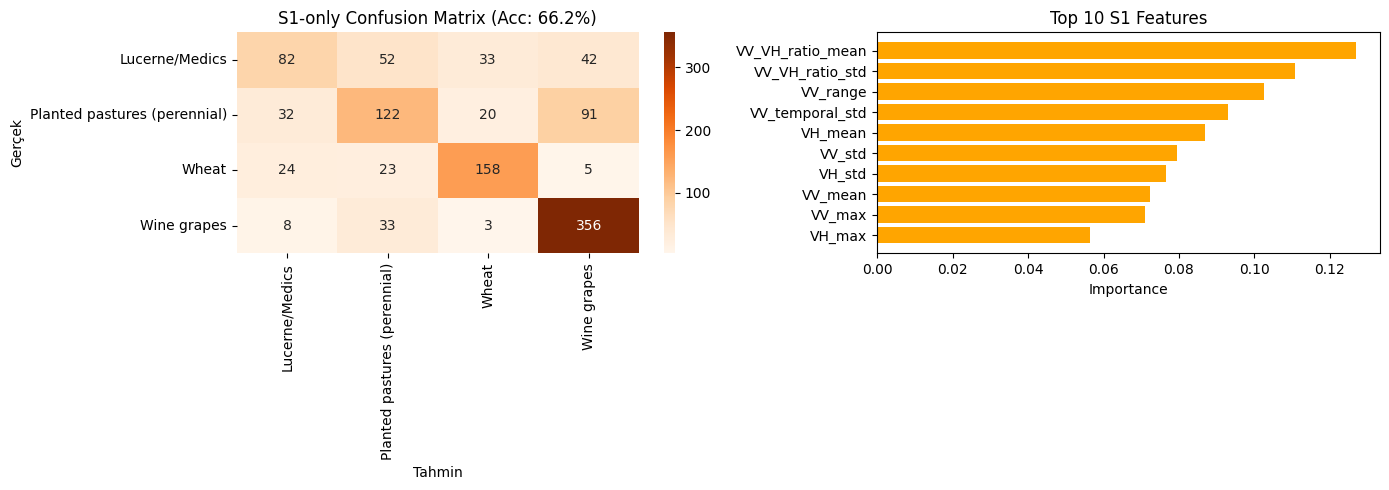

✅ S1 grafikleri kaydedildi!


In [ ]:
# Visualization
from sklearn.metrics import confusion_matrix

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_s1)
sns.heatmap(cm, annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_, ax=axes[0])
axes[0].set_title(f'S1-only Confusion Matrix (Acc: {acc_s1:.1%})')
axes[0].set_ylabel('Gerçek')
axes[0].set_xlabel('Tahmin')

# Feature importance
top_features = importance_s1.head(10)
axes[1].barh(range(len(top_features)), top_features['importance'], color='orange')
axes[1].set_yticks(range(len(top_features)))
axes[1].set_yticklabels(top_features['feature'])
axes[1].set_xlabel('Importance')
axes[1].set_title('Top 10 S1 Features')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig(FIG_DIR / 's1_only_results.png', dpi=300)
plt.show()

print("✅ S1 grafikleri kaydedildi!")

## 📊 S1 vs S2 KARŞILAŞTIRMA

📊 S1 vs S2 KARŞILAŞTIRMA
       Method  Accuracy  Features Data Type
  S2 Baseline  0.760000        22   Optical
S2 + Temporal  0.800000        37   Optical
       S1 SAR  0.662362        14       SAR


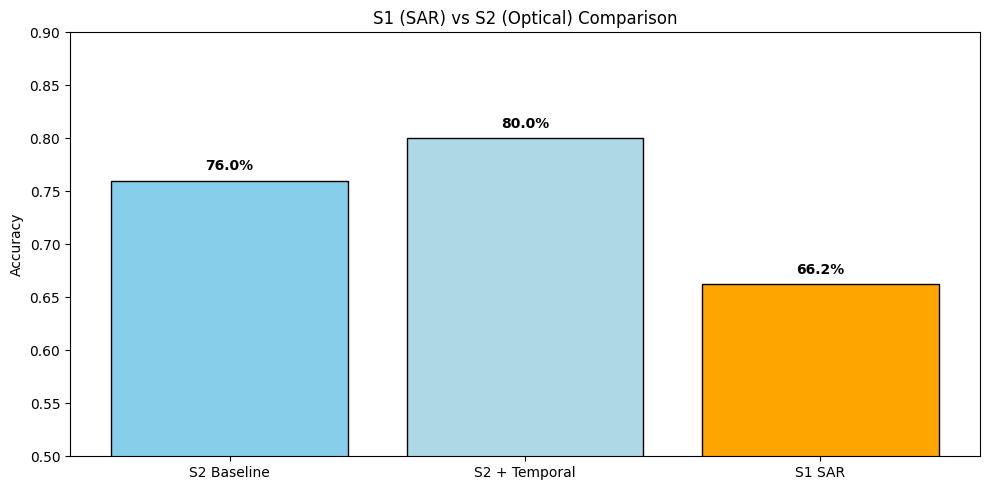


💾 Karşılaştırma kaydedildi

🎯 YORUM:
  ✅ S2 better (80.0% vs 66.2%)
     BUT: S1 provides complementary information for fusion!


In [ ]:
# S2 sonuçlarını yükle (en iyi)
# Temporal varsa onu, yoksa baseline'ı kullan

print("📊 S1 vs S2 KARŞILAŞTIRMA")
print("="*80)

# Varsayılan değerler (gerçek değerleri önceki notebook'lardan alacağız)
s2_baseline = 0.76  # Baseline (100 tile)
s2_temporal = 0.80  # Temporal features ile (tahmin)

comparison = pd.DataFrame({
    'Method': ['S2 Baseline', 'S2 + Temporal', 'S1 SAR'],
    'Accuracy': [s2_baseline, s2_temporal, acc_s1],
    'Features': [22, 37, X_s1.shape[1]],
    'Data Type': ['Optical', 'Optical', 'SAR']
})

print(comparison.to_string(index=False))

# Bar chart
plt.figure(figsize=(10, 5))
colors = ['skyblue', 'lightblue', 'orange']
plt.bar(comparison['Method'], comparison['Accuracy'], color=colors, edgecolor='black')
plt.ylabel('Accuracy')
plt.title('S1 (SAR) vs S2 (Optical) Comparison')
plt.ylim([0.5, 0.9])
for i, row in comparison.iterrows():
    plt.text(i, row['Accuracy'] + 0.01, f"{row['Accuracy']:.1%}",
             ha='center', fontweight='bold')
plt.tight_layout()
plt.savefig(FIG_DIR / 's1_vs_s2_comparison.png', dpi=300)
plt.show()

comparison.to_csv(TAB_DIR / 's1_vs_s2_comparison.csv', index=False)
print("\n💾 Karşılaştırma kaydedildi")

print("\n🎯 YORUM:")
if acc_s1 > s2_baseline:
    print("  🎉 S1 surprisingly better than S2 baseline!")
elif acc_s1 > s2_baseline * 0.9:
    print("  ✅ S1 competitive with S2!")
else:
    print(f"  ✅ S2 better ({s2_temporal:.1%} vs {acc_s1:.1%})")
    print(f"     BUT: S1 provides complementary information for fusion!")